# Let's vizulaize CNN by Keras!

1. 準備 (普通にCNN)
2. フィルターの可視化
3. （フィルター後の）中間データの可視化

以下のサイトを参考にした。

http://euler.stat.yale.edu/~tba3/stat665/lectures/lec17/notebook17.html
https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb

## 1. まずは普通にCNN

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kerasで必要なものをimport
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

# データを用意＆加工
size_img = 28
n_label = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
X_test = X_test.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
Y_train = np_utils.to_categorical(y_train, n_label)
Y_test = np_utils.to_categorical(y_test, n_label)

label :  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


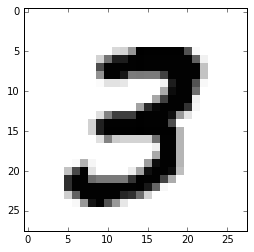

In [5]:
# 試しに、どんなインプットイメージが見てみる
%matplotlib inline
import matplotlib.cm as cm

i = 7
plt.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [17]:
# CNNモデルの構築
# 単純なconv1層 x full connect1層モデル
n_filter = 16
size_filter = 5
size_pool = 2
n_hidden = 100

model = Sequential()
model.add(Convolution2D(n_filter, size_filter, size_filter,
                        border_mode='same', input_shape = (1, size_img, size_img)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Dropout(0.2))
model.add(Dense(n_label))
model.add(Activation('softmax'))
          
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [18]:
# 学習
model.fit(X_train, Y_train, batch_size=50, nb_epoch=10,
          verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 45s - loss: 0.2066 - acc: 0.9382 - val_loss: 0.0660 - val_acc: 0.9808
Epoch 2/10
54000/54000 [==============================] - 50s - loss: 0.0845 - acc: 0.9750 - val_loss: 0.0547 - val_acc: 0.9850
Epoch 3/10
54000/54000 [==============================] - 48s - loss: 0.0683 - acc: 0.9789 - val_loss: 0.0439 - val_acc: 0.9878
Epoch 4/10
54000/54000 [==============================] - 48s - loss: 0.0583 - acc: 0.9817 - val_loss: 0.0426 - val_acc: 0.9868
Epoch 5/10
54000/54000 [==============================] - 48s - loss: 0.0506 - acc: 0.9840 - val_loss: 0.0432 - val_acc: 0.9893
Epoch 6/10
54000/54000 [==============================] - 48s - loss: 0.0459 - acc: 0.9854 - val_loss: 0.0470 - val_acc: 0.9877
Epoch 7/10
54000/54000 [==============================] - 48s - loss: 0.0428 - acc: 0.9864 - val_loss: 0.0375 - val_acc: 0.9900
Epoch 8/10
54000/54000 [==============================]

In [19]:
vs = model.evaluate(X_test, Y_test)
print("\nTest classification rate %0.05f" % vs[1])
# ~99%と高い正解率

 9984/10000 [============================>.] - ETA: 0s
Test classification rate 0.98840


In [20]:
# 正誤表
print('Cross tabulation')
y_pred = model.predict_classes(X_test)
pd.crosstab(y_pred, y_test)

Cross tabulation
 9984/10000 [============================>.] - ETA: 0s

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,972,0,0,0,1,1,3,0,5,0
1,0,1130,1,0,0,0,1,1,2,1
2,4,1,1023,3,0,0,0,5,0,1
3,1,2,0,995,0,4,1,1,2,4
4,0,0,1,0,973,0,1,0,1,2
5,0,1,0,9,0,884,5,0,2,4
6,1,1,0,0,1,1,943,0,0,0
7,0,0,6,1,0,0,0,1018,1,5
8,2,0,1,1,1,0,4,1,957,3


### コメント
列：実際の数字  
行：予想した数字  

予想した数字が正しければ、対角部分にカウントされる。正解率が~99%なので、もちろんほとんどの数字がここにカウントされる。  
むしろ気になるには間違えた数字。どんな数字が間違われやすいのか？  
* 1は単純なので、他の数字に間違われにくい。   
* 0, 6, 8, 9のように形に円を含む数字は、他の数字に間違えられやすい傾向にある。　  
* 2/7, 3/5を混同する間違いが多い。　  

116


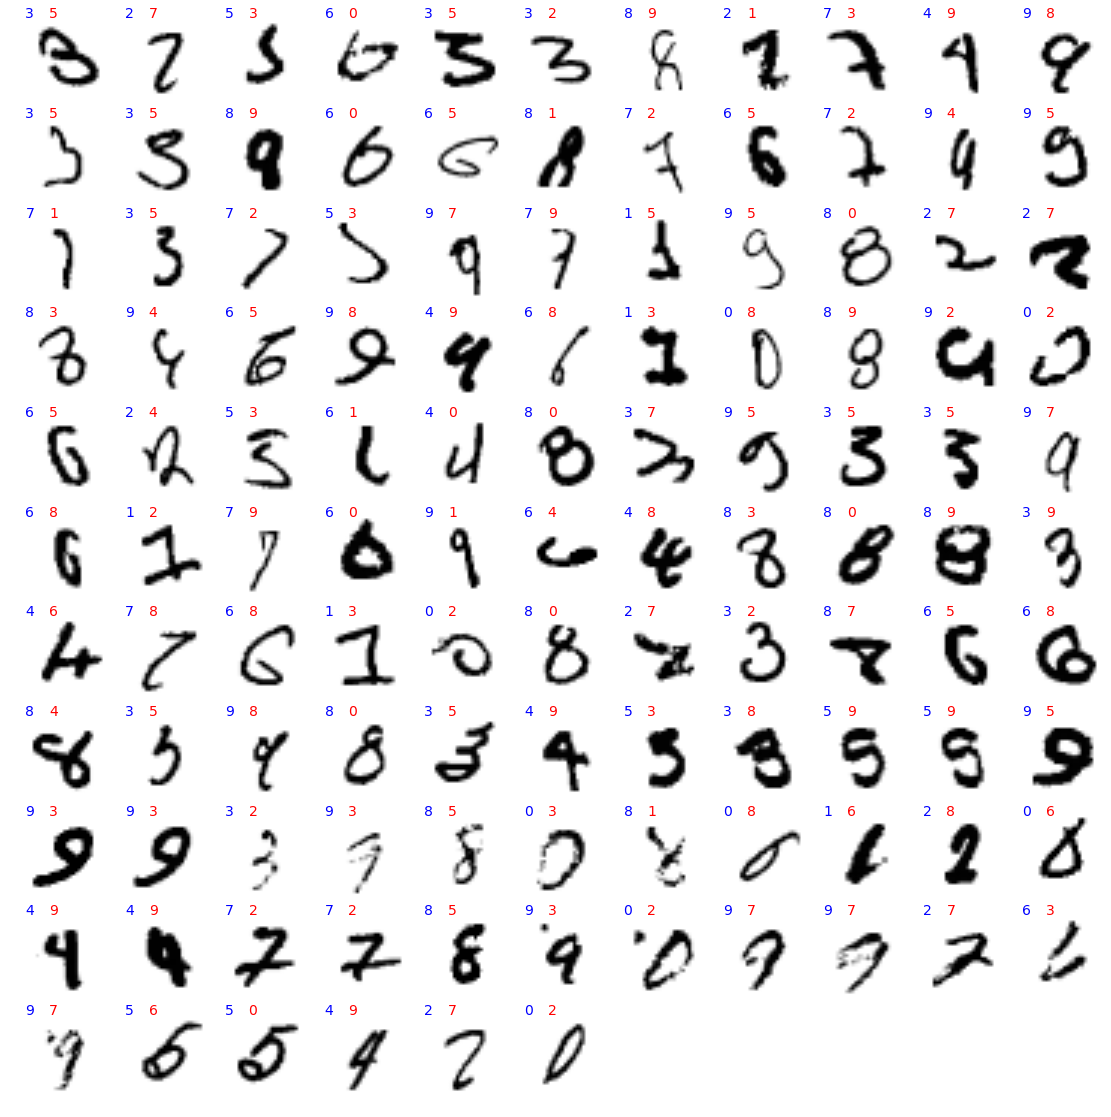

In [43]:
# そこで実際に、間違いの数字を見る。
# 青ラベル：実際の数字；赤ラベル：間違えて予測した数字
test_wrong = [im for im in zip(X_test, y_pred, y_test)
              if im[1] != im[2]]
print(len(test_wrong))

plt.figure(figsize=(15, 15))
for ind, val in enumerate(test_wrong):
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.subplot(11, 11, ind + 1)
    im = 1 - val[0][0]
    plt.axis("off")
    plt.imshow(im, cmap='gray')
    plt.text(8, 0, val[1], fontsize=14, color='red')
    plt.text(0, 0, val[2], fontsize=14, color='blue')
#     break

* 青ラベル：実際の数字
* 赤ラベル：間違えて予測した数字

### 考察

人が見ても間違えてしまいそうなペアも少しあるが、人なら間違わないペアの方が多いように見える。特に、上表で見た通り「円」が数字に含まれている数字は、人なら絶対にしないような間違いが多い。円状の一部が欠けているものを円と判断しなかったり、逆に円でないのに一部の突起のような部分のみで円であると判断したりしている。
おそらく、convolutionのfilterに「円」を認識する能力が欠如していると考えられる。

そんなわけで、以下filterを見てみる。

# Vizualization

## 2. フィルターの可視化

In [24]:
# Kerasでは、以下のように簡単にレイヤーごとのパラメータが取得できる
lays = model.layers # list of the layers
for i, l in enumerate(lays):
    print(i+1, l)
w1 = model.layers[0].get_weights()[0] # 1層目（i=0）のレイヤーのweights
b1 = model.layers[0].get_weights()[1] # とbiasのshape

print(w1.shape, b1.shape)
print(model.layers[7].get_weights()[0].shape) # Dense

1 <keras.layers.convolutional.Convolution2D object at 0x1332bceb8>
2 <keras.layers.core.Activation object at 0x1329fe860>
3 <keras.layers.pooling.MaxPooling2D object at 0x1332bce10>
4 <keras.layers.core.Dropout object at 0x1332bcba8>
5 <keras.layers.core.Flatten object at 0x1329f6a90>
6 <keras.layers.core.Dense object at 0x1354c5eb8>
7 <keras.layers.core.Dropout object at 0x131ee6748>
8 <keras.layers.core.Dense object at 0x131dc90f0>
9 <keras.layers.core.Activation object at 0x131dceba8>
(16, 1, 5, 5) (16,)
(100, 10)


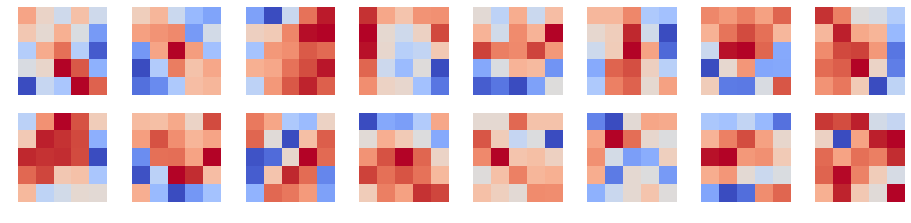

In [46]:
w1 = model.layers[0].get_weights()[0]

plt.figure(figsize=(16, 3.5))
for ind, val in enumerate(w1):
    plt.subplot(2, 8, ind + 1)
    im = val.reshape((size_filter, size_filter))
    plt.axis("off")
    plt.imshow(im, cmap='coolwarm',interpolation='nearest')
#     break

### 考察
filterは、赤が大きく青が小さい。  
縦、横、斜め、L字の形状はあるが円状のものはない。円の形状は、上記の直線状のものを組み合わせて判断しているのだろう。  
そのため前述したように、「円」そのものでなく、その一部の形を見て判断したような間違いが多いのだと推測される。

この推測を確認するため、間違えた数字をもう少し詳しく見てみる。

## 3. 中間データの可視化

In [75]:
# 正しく評価した/していないimageを取得する関数
def get_imgs(num, flg_correct=True):
    if flg_correct:
        mask = (y_test == num) & (y_pred == y_test)
    else:
        mask = (y_test == num) & (y_pred != y_test)
    return X_test[mask], y_pred[mask]

In [ ]:
# 2層目まで（convolution -> relu)を取得
layers = model.layers.copy()[:2]  

# 新しいmodel(model2)にlayerを入れる
model2 = Sequential()
for layer in layers:
    model2.add(layer)
model2.compile(loss='categorical_crossentropy', optimizer='RMSprop')  # compileするだけ (loss, optimizerは使わない)

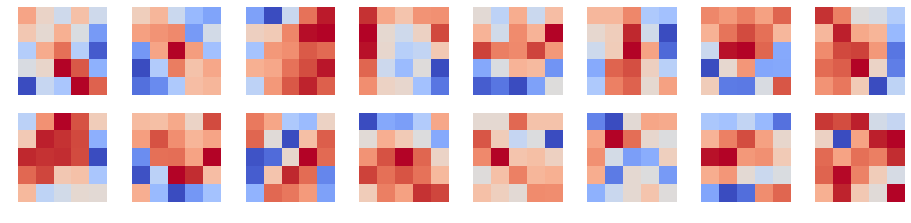

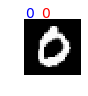

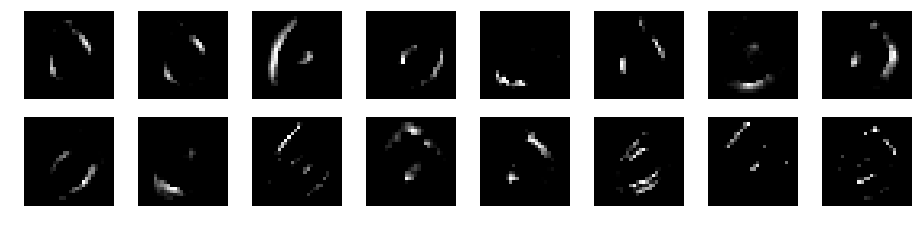

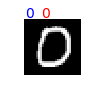

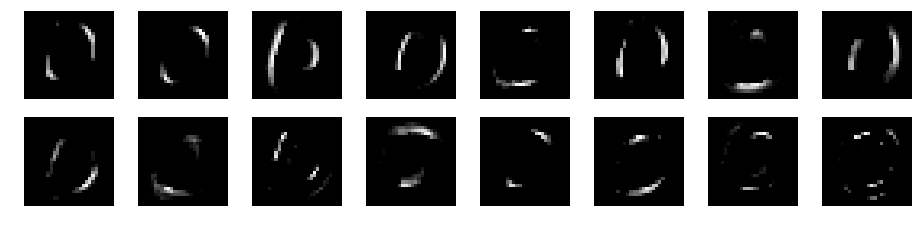

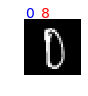

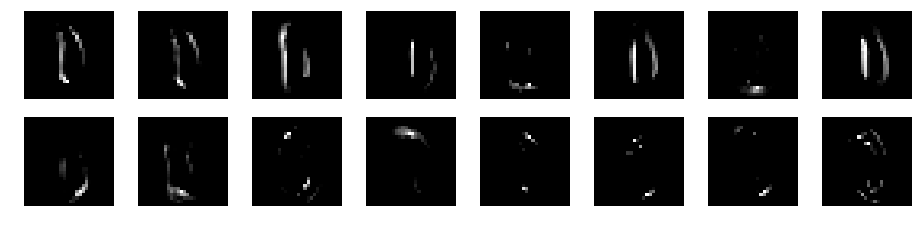

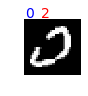

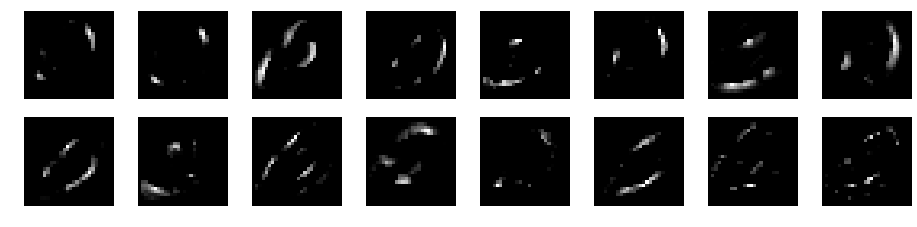

In [83]:
num = 0  # 表示する数字
m = 2  # 表示する数字の枚数

# filterを表示 ---------------------------------
w1 = model2.layers[0].get_weights()[0]
plt.figure(figsize=(16, 3.5))
for i, val in enumerate(w1):
    plt.subplot(2, 8, i + 1)
    im = val.reshape((size_filter, size_filter))
    plt.axis("off")
    plt.imshow(im, cmap='coolwarm',interpolation='nearest')

    
# 合っているイメージと間違っているイメージを取得 ----------------------
xs_correct, nums_correct = get_imgs(num, flg_correct=True)
xs_wrong, nums_wrong = get_imgs(num, flg_correct=False)
# m枚ずつ抜き出しmerge
xs = np.concatenate([xs_correct[:m], xs_wrong[:m]])
ys = np.concatenate([nums_correct[:m], nums_wrong[:m]])
# filterd imagesを取得
imgs_f = model2.predict(xs)


# 表示 -------------------------------------------
for x, num_pred, img_f in zip(xs, ys, imgs_f):
    # 元イメージ
    plt.figure(figsize=(1, 1))
    plt.axis('off')
    plt.imshow(x[0], cmap='gray',interpolation='nearest')
    plt.text(0, -1, num, fontsize=14, color='blue')
    plt.text(8, -1, num_pred, fontsize=14, color='red')
    # filter後のイメージ
    plt.figure(figsize=(16, 3.5))
    for i, img in enumerate(img_f):
        plt.subplot(2, 8, i + 1)
        plt.axis('off')
        plt.imshow(img, cmap='gray',interpolation='nearest')
#     break

### 考察
* 青ラベル：実際の数字
* 赤ラベル：予測した数字

16枚のfilter ->
(input image -> 16のfilterを通したそれぞれのimage)を(正解2枚 + 不正解2枚)表示。

0の場合で、正しく予想した場合と間違って予想した場合を比較してみた。
予想通り、filterされたイメージは、16のfilterの特性に合わせてそれぞれ縦、横、斜めにfilteringされており、イメージの中には「円状」のものはない。やはり縦、横、斜めに断片化されたイメージを組み合わせて「円」と認識していると考えられる。

正しく認識されている場合はわかりやすく、人がこの16枚のfiltered imageから判断しても「0」と推測するだろう。

面白いのは間違っている場合で、一つ目の例では明らかに0なのに8と間違えている。おそらく、（特に左の）縦線が曲線でなく真っ直ぐ引かれているため、0と認識されなかったと思われる（正解の場合に比べ「斜めfilter」への反応が顕著でない）。だからといって8には間違えないだろうと思うのだが、このCNNだと8を正しく推測するのが難しそうだ（下のセル参照）。人は8を「円が2つ」と認識していると思うが、このCNNではそのように認識していない。人なら最も注目するであろう、8の中心の結び目('X')部分があまり強調されていない＝そのようなfilterがない。これが0と間違いが出る原因と思われる。

2番目の間違いの例も面白い。間違いの原因は左の線が途中で切れていることだろうが、人であれば簡単に「補完」して0とみなせる。こういう補完に関してはCNNもMaxpoolingで対応しているはずだが、この数字に関してはMaxpoolingで対応できる範囲を超えて離れてしまったのだろう。

人は直線だけでなく円の大きさなども、（おそらく）イメージに合わせてスケールして認識することができる。これはCNNでいえばfilter sizeをイメージに合わせて、大きくしたり小さくしたり適宜合わせていることに相当する（はず）。同じように、ちょっと離れすぎていてもイメージごとに柔軟に補完の大きさを変更することもできる。なので、上記のようなCNNの間違いを不思議に思う。

今回の単純なCNNではconvolution/Maxpoolingのfilterの大きさは固定化されている。
そのような制約の中では、どのようなイメージにでも汎用的に使えるfilterは直線だけだろう（もっとfilter数を多くしたり、filter sizeを大きくすれば円も現れるかもしれない）。実際、円といっても8の円と0の円では大きさが異なるし、書いた人によっても大きさは異なる。固定化されたfilterでは、人のように柔軟に形を検出するのが難しそうなのは直感的にも納得できる。

むしろこんな単純なモデルで~99%の正解率がであることが驚異的。ただ忘れちゃいけないのは、インプットされている数字は人によって事前にtrimingされたりリスケールされたりしていること。つまりCNNが苦手とする柔軟にスケールする部分がなくても大丈夫なように、イメージのサイズや場所ができるだけ「固定化」されていることは気をつけたい。

### 最後に
一番最後のセルに、0-9までの数字について同様の比較を行っておく。
間違えても仕方がないというものから、上記の考察が当てはまる間違い、よくわからない間違いなど色々ある。  
これ以上の考察はしないが、眺めていると他の法則などもわかるかもしれない。

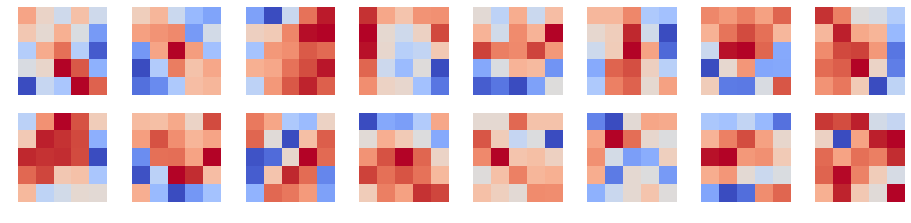

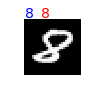

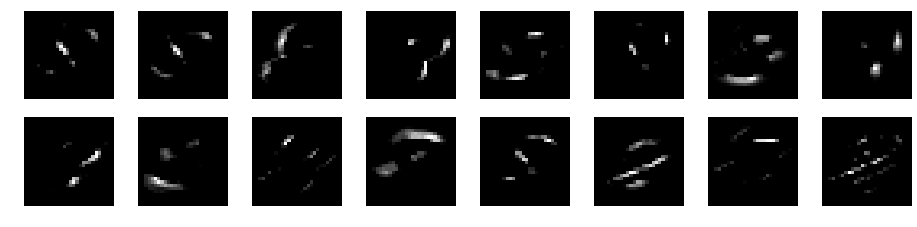

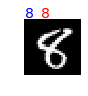

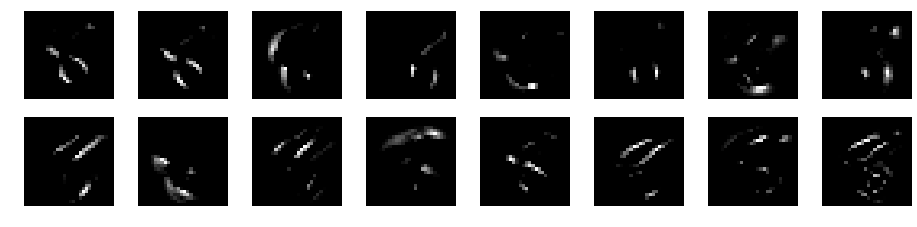

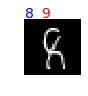

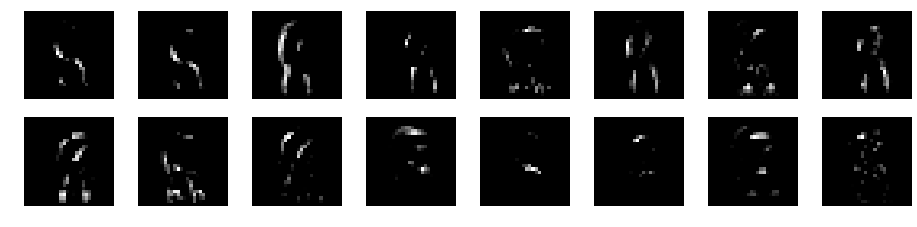

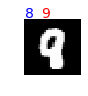

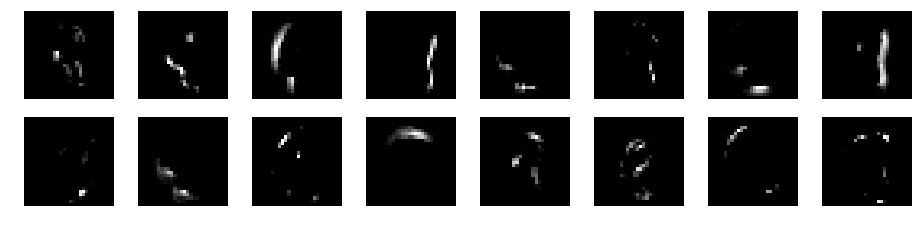

In [84]:
num = 8  # 表示する数字
m = 2  # 表示する数字の枚数

# filterを表示 ---------------------------------
w1 = model2.layers[0].get_weights()[0]
plt.figure(figsize=(16, 3.5))
for i, val in enumerate(w1):
    plt.subplot(2, 8, i + 1)
    im = val.reshape((size_filter, size_filter))
    plt.axis("off")
    plt.imshow(im, cmap='coolwarm',interpolation='nearest')

    
# 合っているイメージと間違っているイメージを取得 ----------------------
xs_correct, nums_correct = get_imgs(num, flg_correct=True)
xs_wrong, nums_wrong = get_imgs(num, flg_correct=False)
# m枚ずつ抜き出しmerge
xs = np.concatenate([xs_correct[:m], xs_wrong[:m]])
ys = np.concatenate([nums_correct[:m], nums_wrong[:m]])
# filterd imagesを取得
imgs_f = model2.predict(xs)


# 表示 -------------------------------------------
for x, num_pred, img_f in zip(xs, ys, imgs_f):
    # 元イメージ
    plt.figure(figsize=(1, 1))
    plt.axis('off')
    plt.imshow(x[0], cmap='gray',interpolation='nearest')
    plt.text(0, -1, num, fontsize=14, color='blue')
    plt.text(8, -1, num_pred, fontsize=14, color='red')
    # filter後のイメージ
    plt.figure(figsize=(16, 3.5))
    for i, img in enumerate(img_f):
        plt.subplot(2, 8, i + 1)
        plt.axis('off')
        plt.imshow(img, cmap='gray',interpolation='nearest')
#     break

/Users/katsuta/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


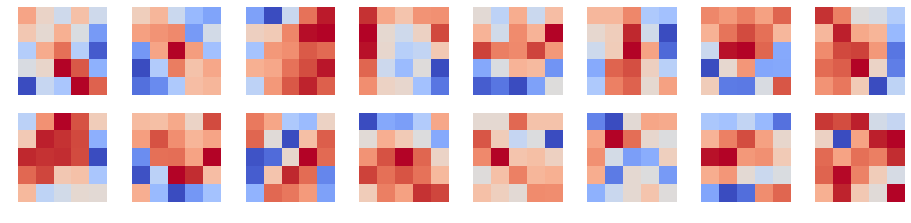

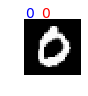

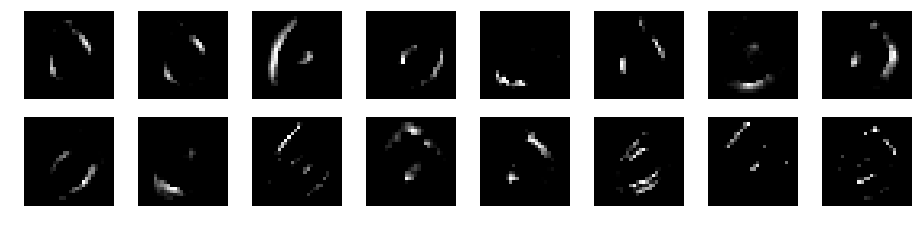

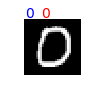

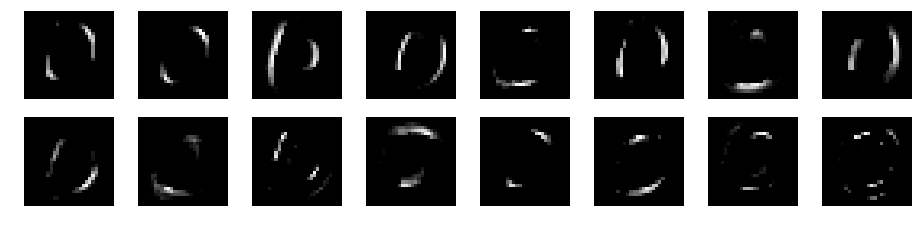

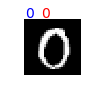

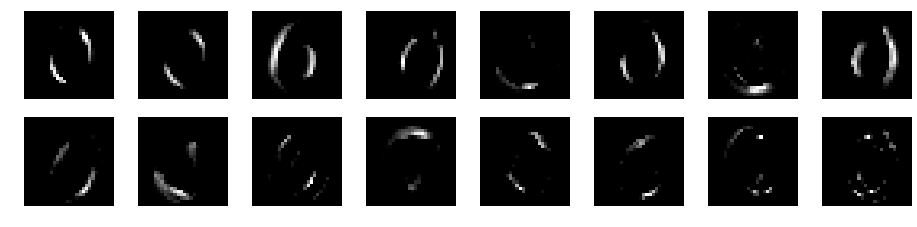

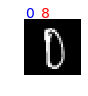

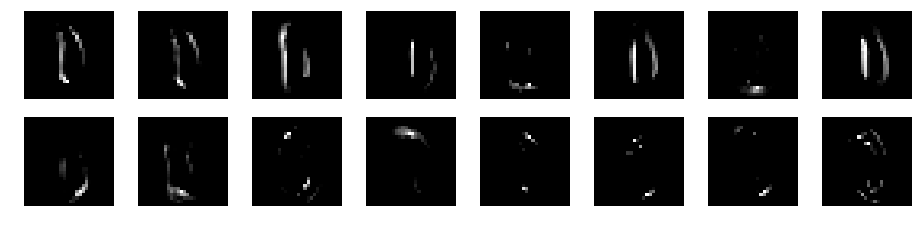

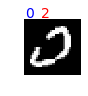

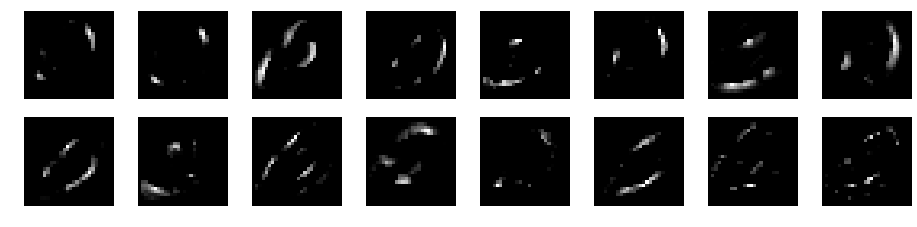

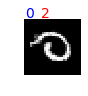

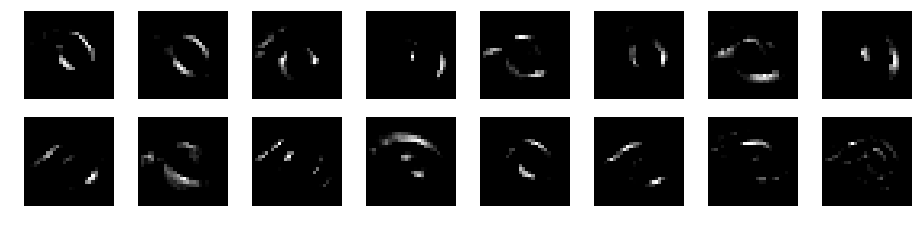

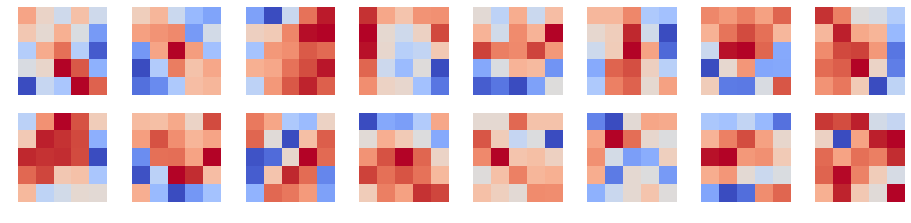

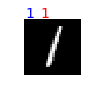

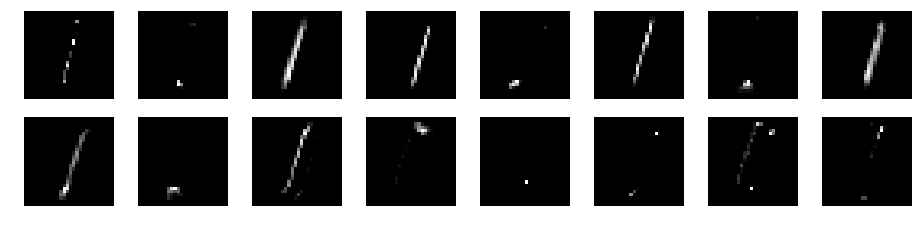

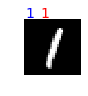

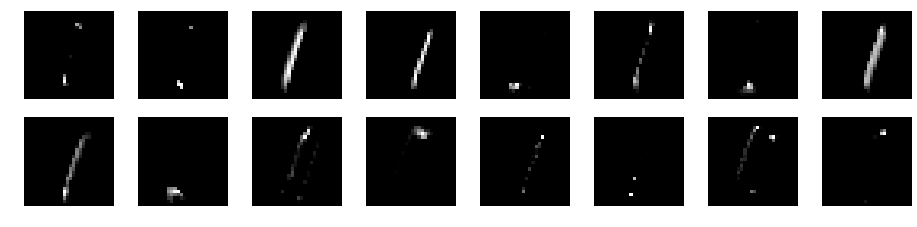

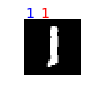

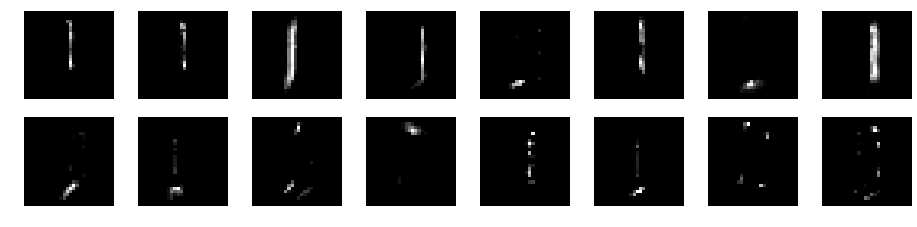

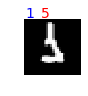

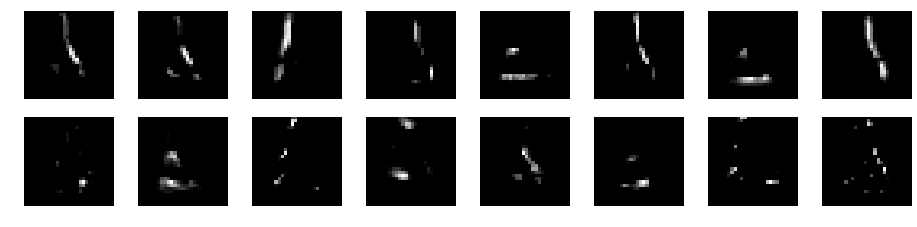

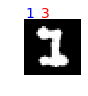

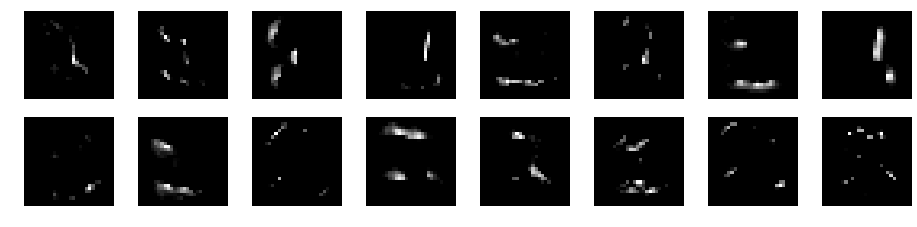

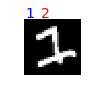

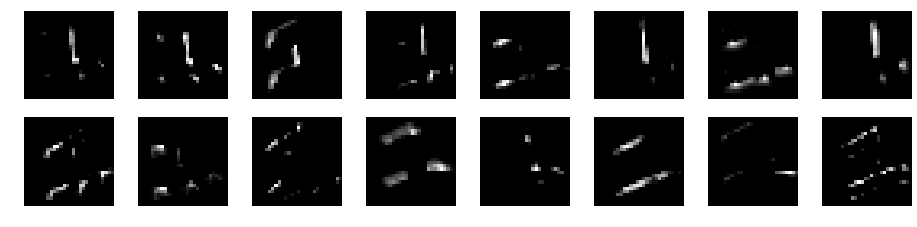

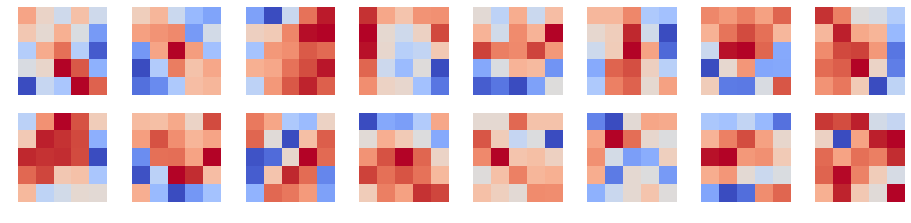

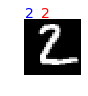

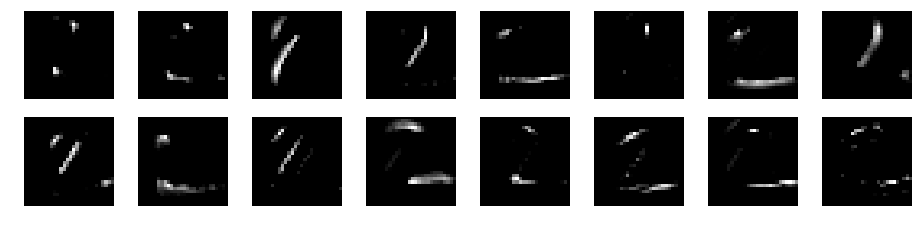

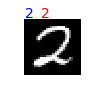

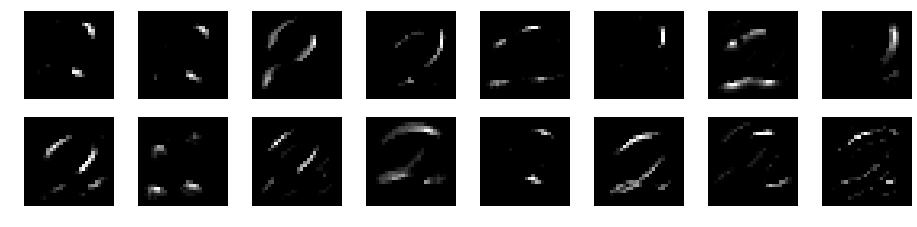

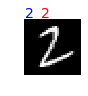

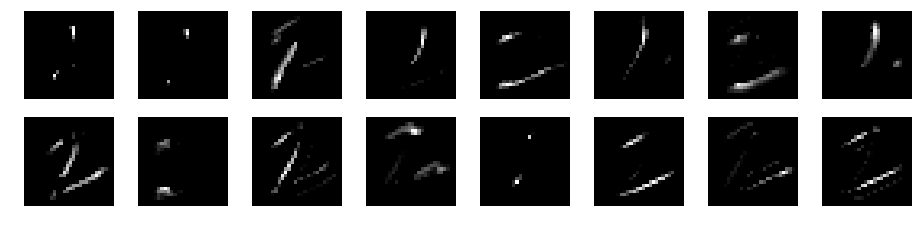

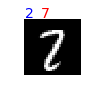

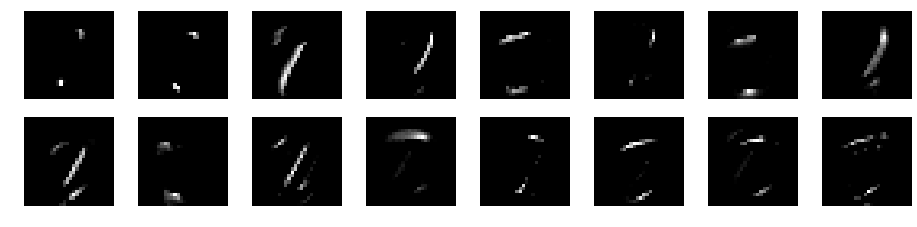

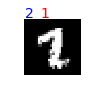

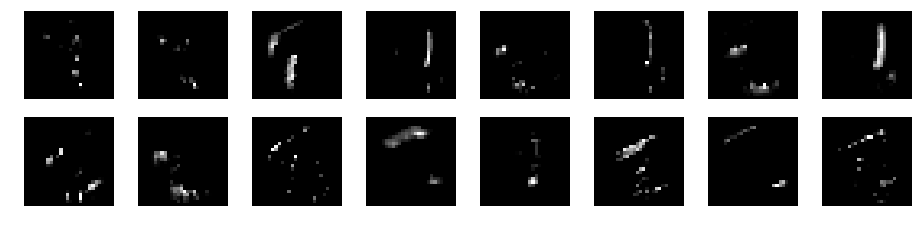

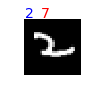

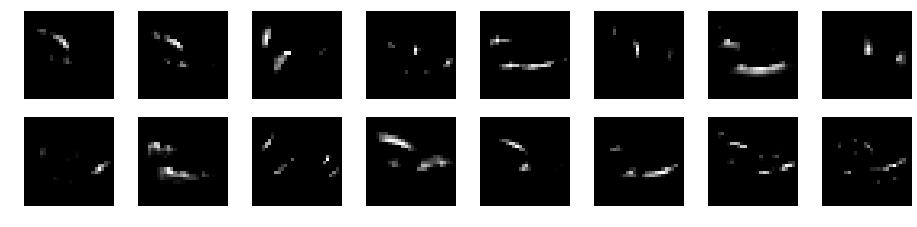

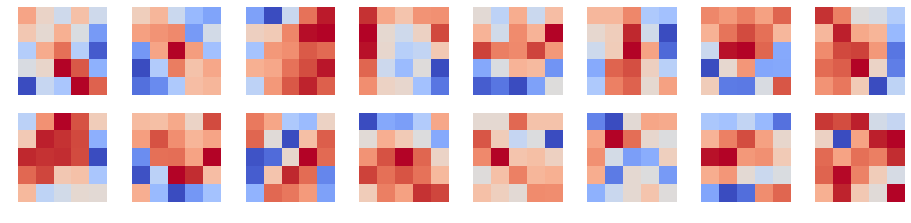

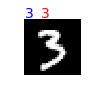

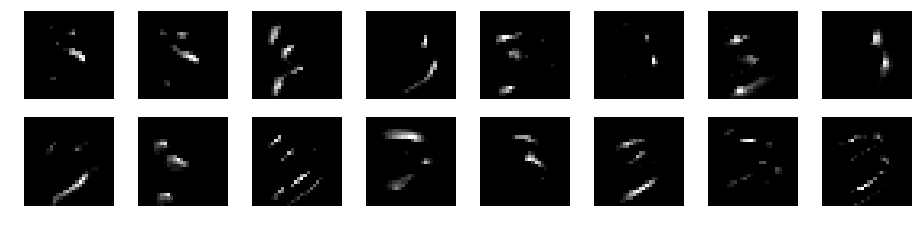

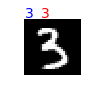

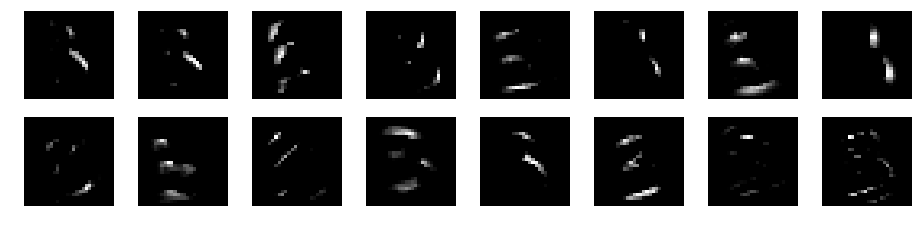

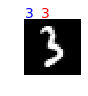

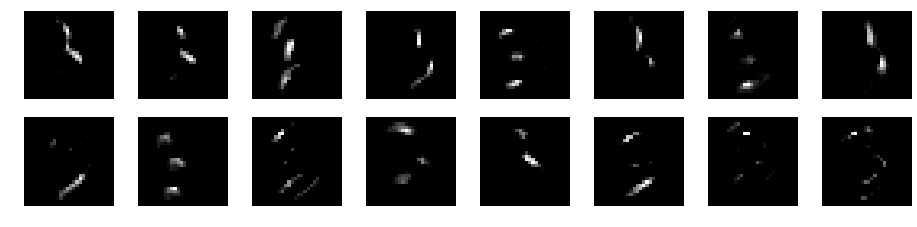

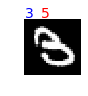

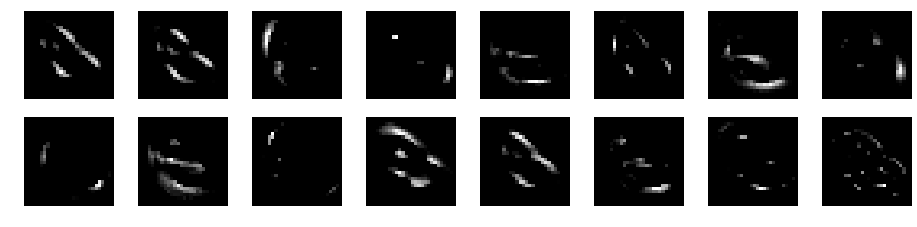

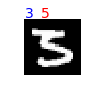

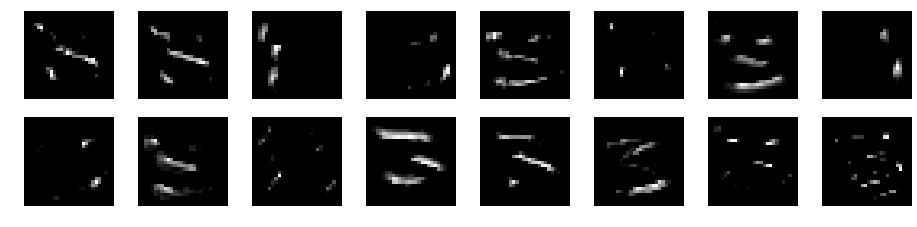

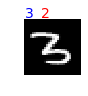

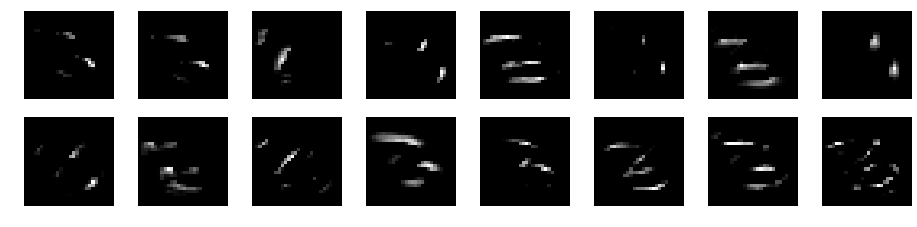

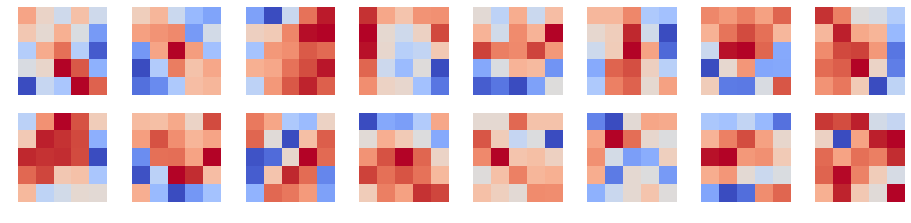

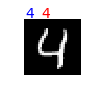

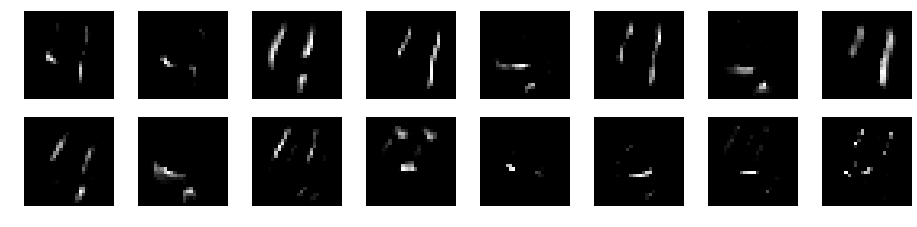

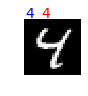

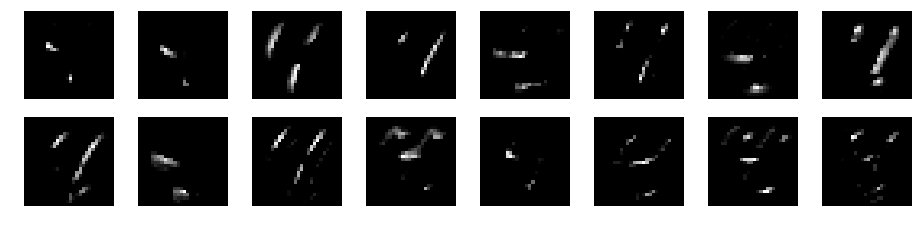

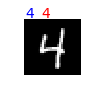

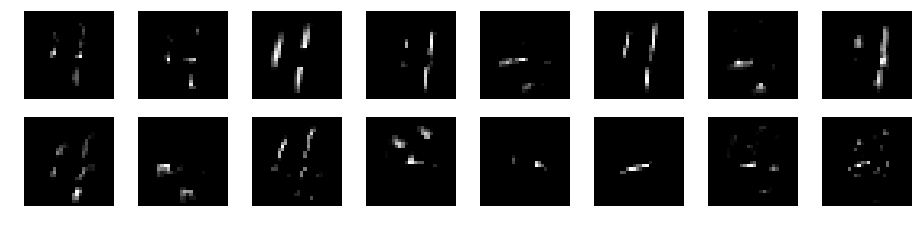

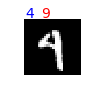

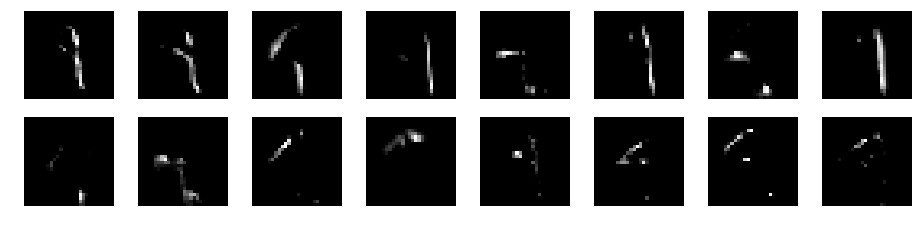

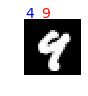

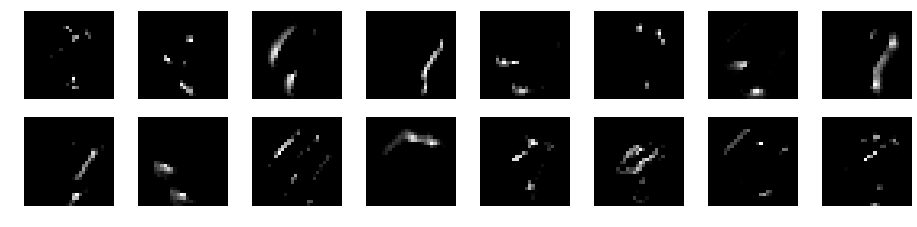

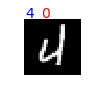

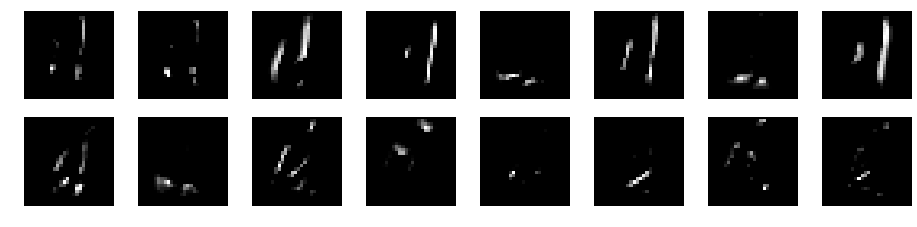

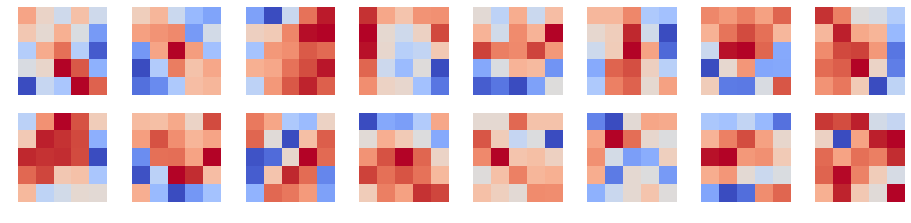

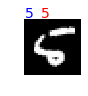

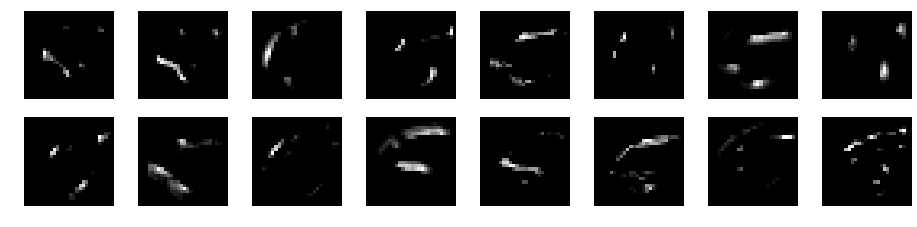

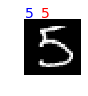

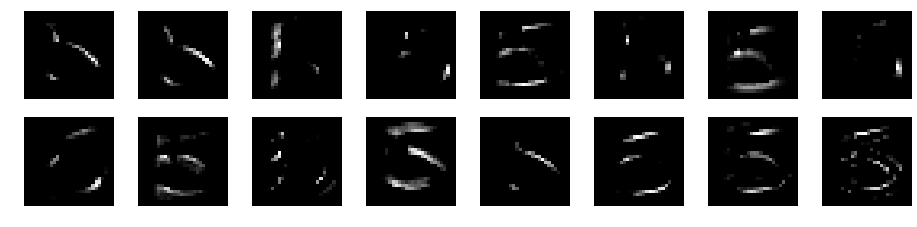

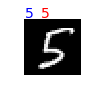

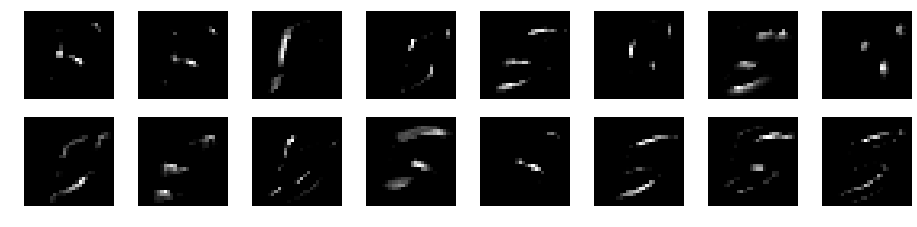

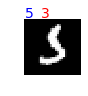

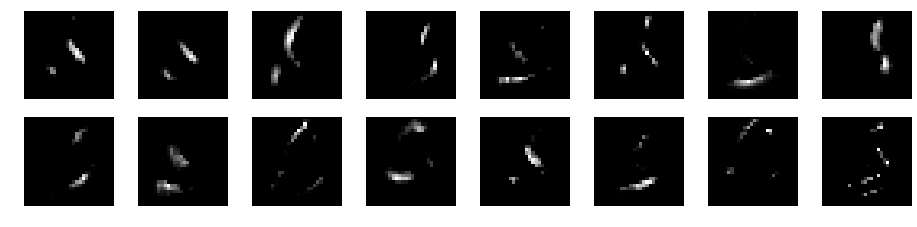

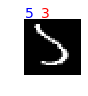

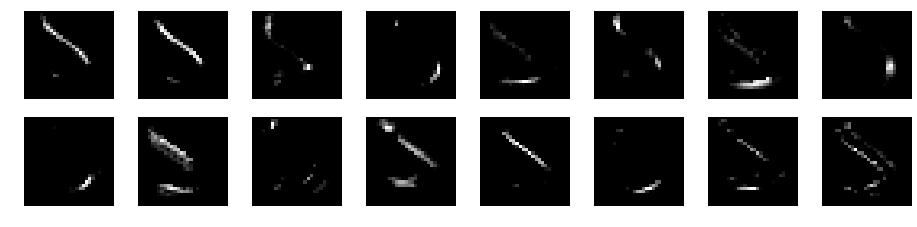

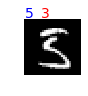

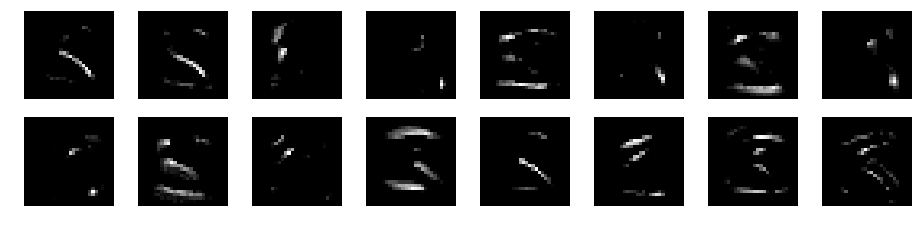

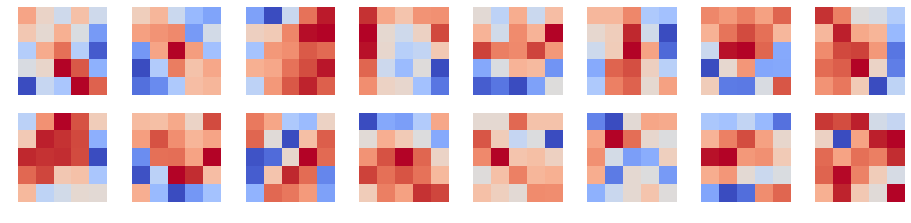

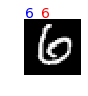

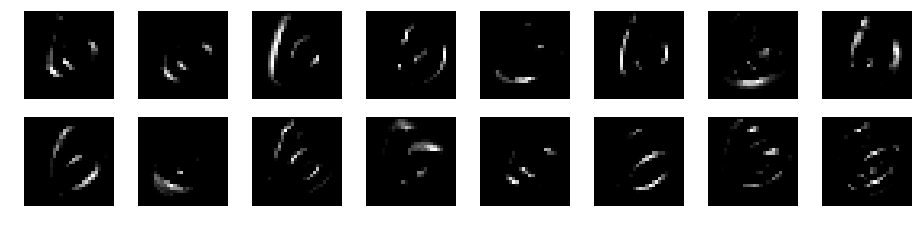

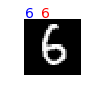

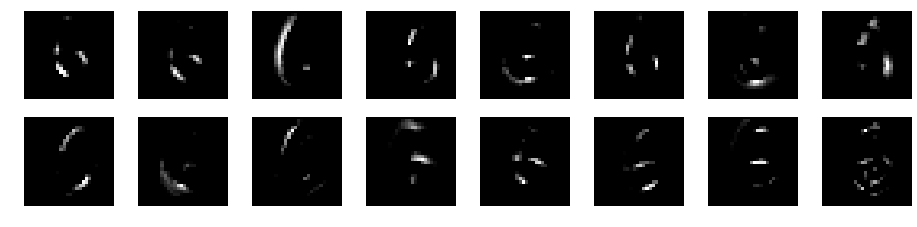

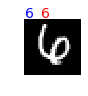

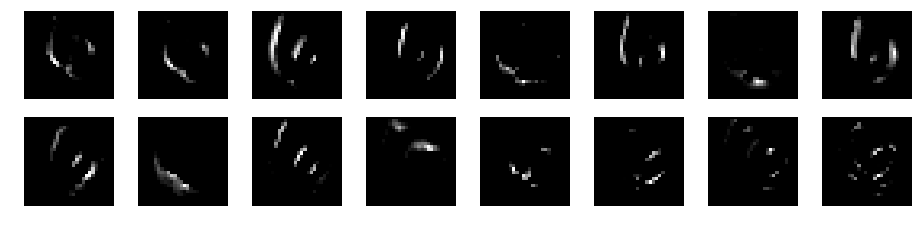

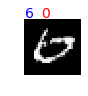

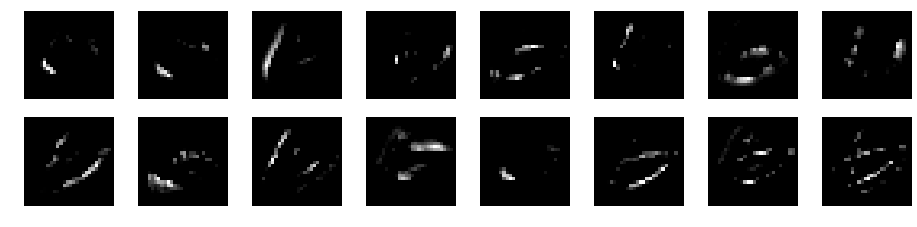

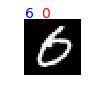

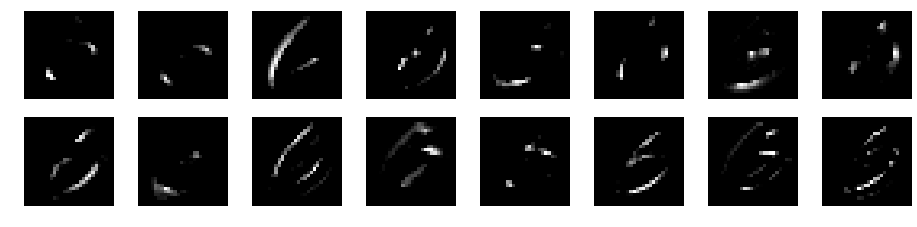

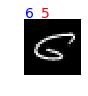

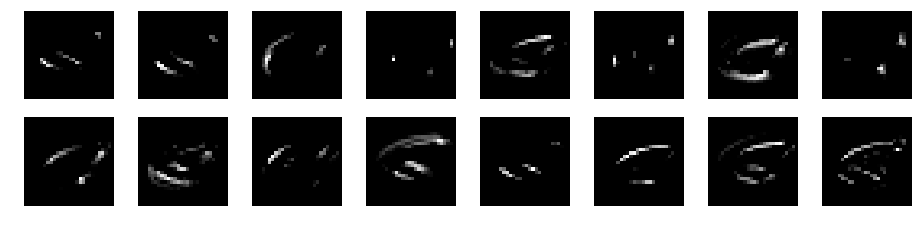

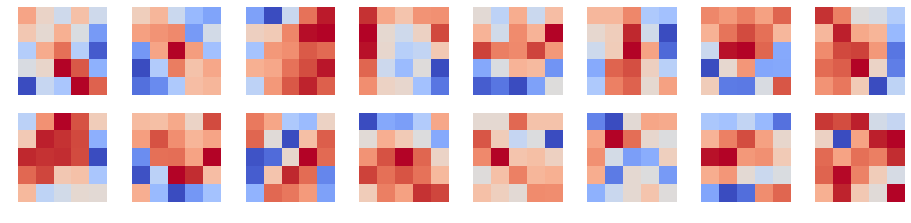

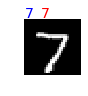

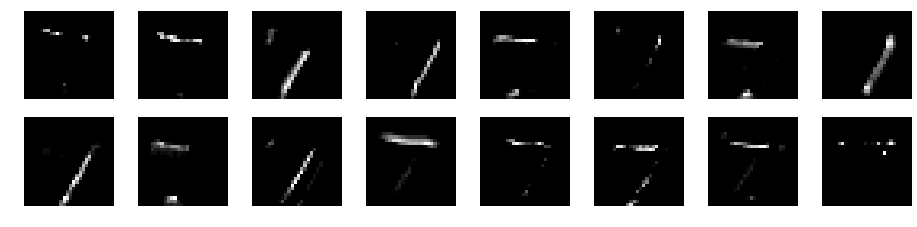

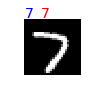

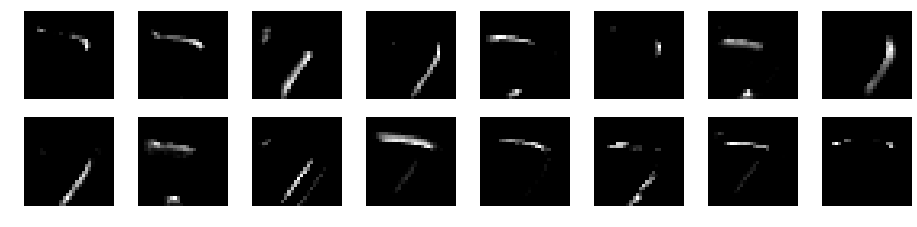

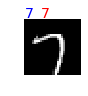

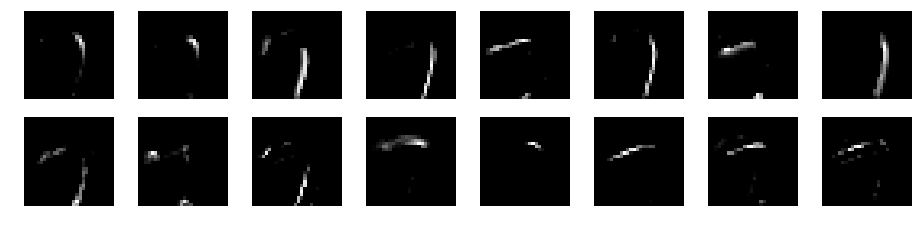

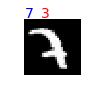

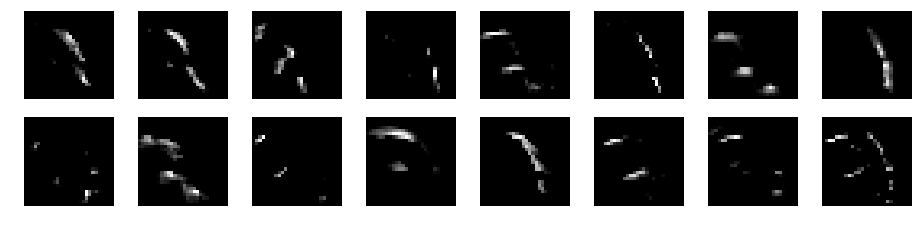

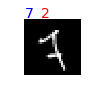

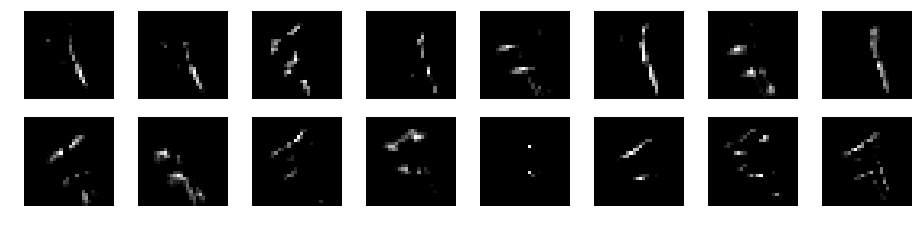

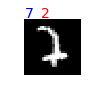

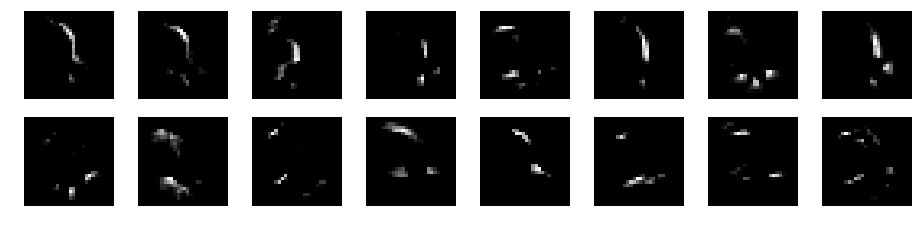

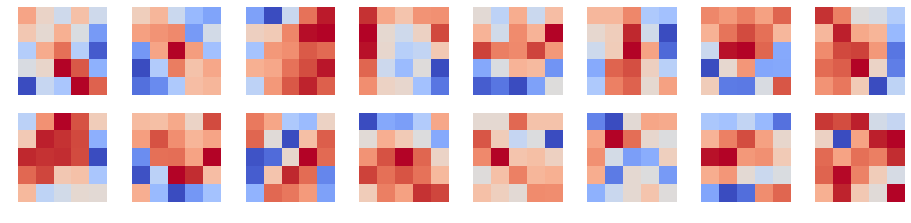

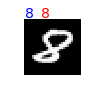

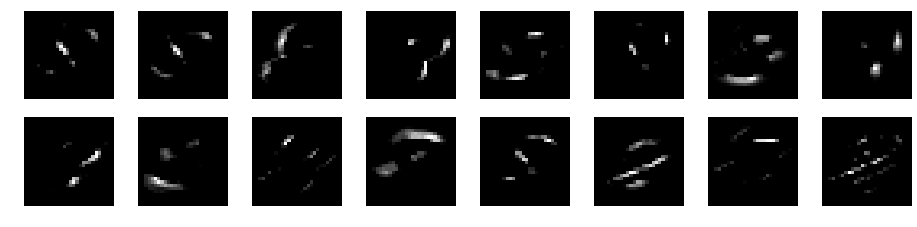

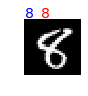

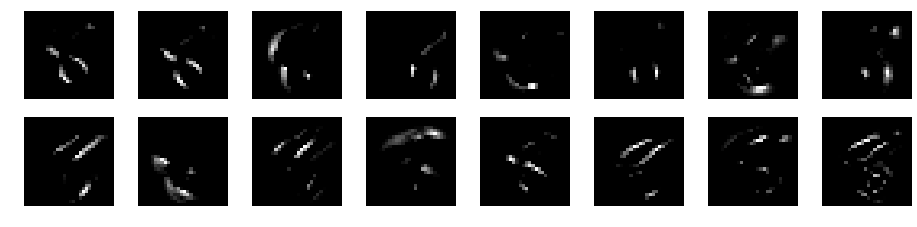

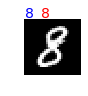

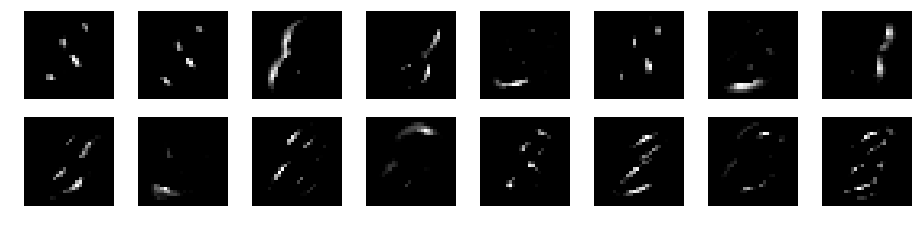

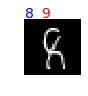

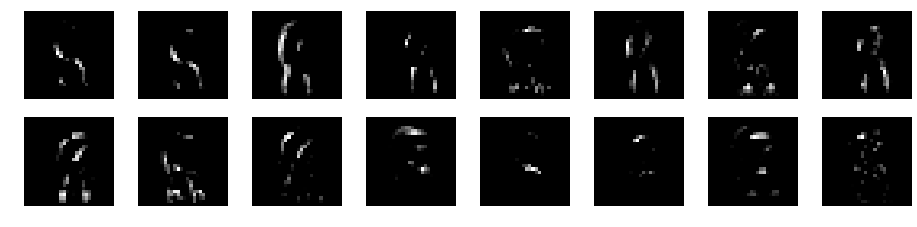

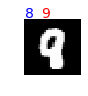

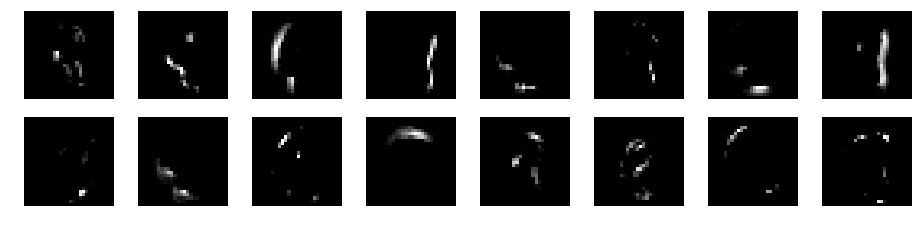

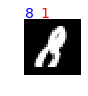

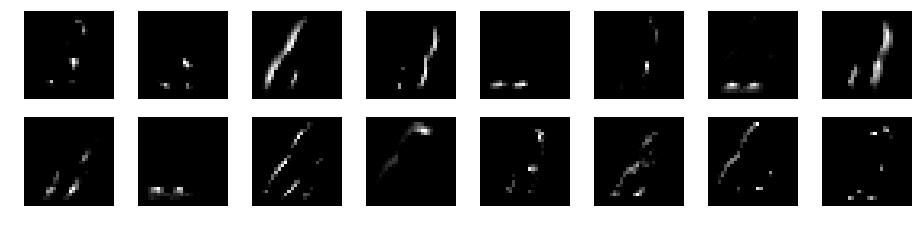

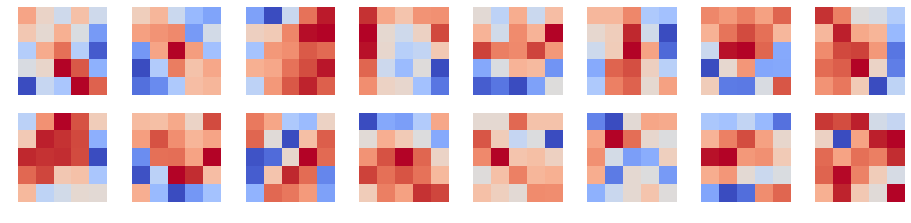

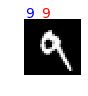

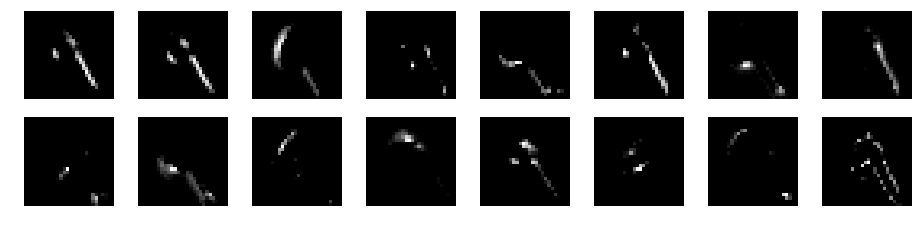

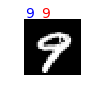

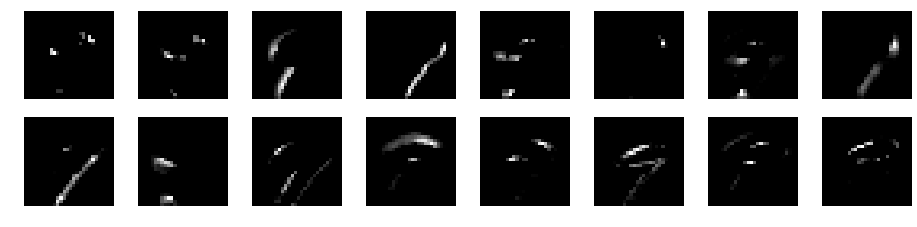

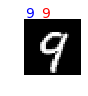

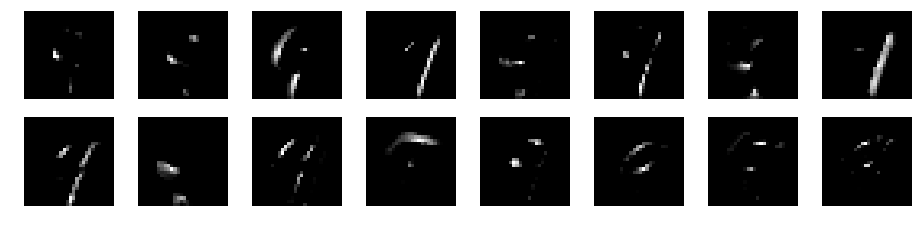

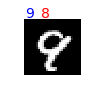

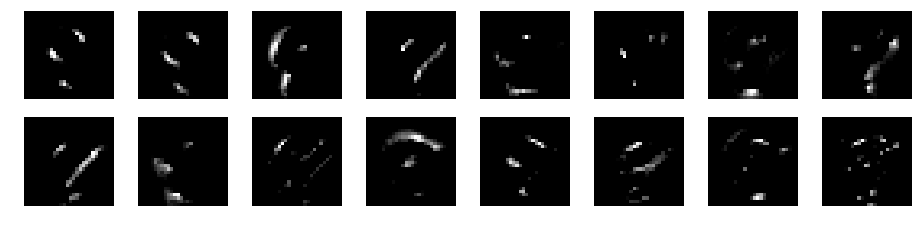

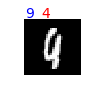

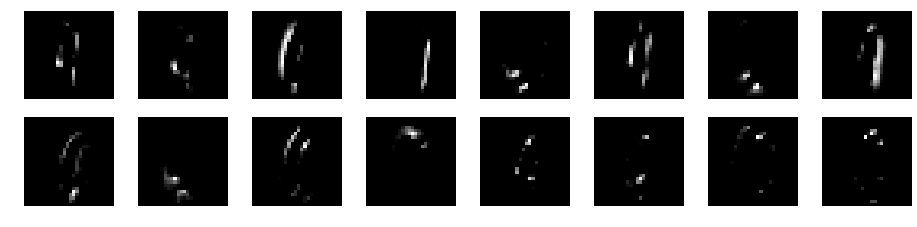

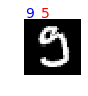

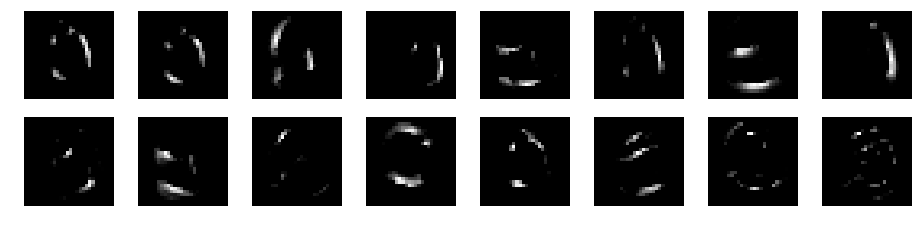

In [81]:
# 0-9までの数字を全て比較
nums = range(10)  # 表示する数字
m = 3  # 表示する数字の枚数

for num in nums:

    # filterを表示 ---------------------------------
    w1 = model2.layers[0].get_weights()[0]
    plt.figure(figsize=(16, 3.5))
    for i, val in enumerate(w1):
        plt.subplot(2, 8, i + 1)
        im = val.reshape((size_filter, size_filter))
        plt.axis("off")
        plt.imshow(im, cmap='coolwarm',interpolation='nearest')


    # 合っているイメージと間違っているイメージを取得 ----------------------
    xs_correct, nums_correct = get_imgs(num, flg_correct=True)
    xs_wrong, nums_wrong = get_imgs(num, flg_correct=False)
    # m枚ずつ抜き出しmerge
    xs = np.concatenate([xs_correct[:m], xs_wrong[:m]])
    ys = np.concatenate([nums_correct[:m], nums_wrong[:m]])
    # filterd imagesを取得
    imgs_f = model2.predict(xs)


    # 表示 -------------------------------------------
    for x, num_pred, img_f in zip(xs, ys, imgs_f):
        # 元イメージ
        plt.figure(figsize=(1, 1))
        plt.axis('off')
        plt.imshow(x[0], cmap='gray',interpolation='nearest')
        plt.text(0, -1, num, fontsize=14, color='blue')
        plt.text(8, -1, num_pred, fontsize=14, color='red')
        # filter後のイメージ
        plt.figure(figsize=(16, 3.5))
        for i, img in enumerate(img_f):
            plt.subplot(2, 8, i + 1)
            plt.axis('off')
            plt.imshow(img, cmap='gray',interpolation='nearest')
    #     break